In [9]:
import os, random, datetime, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.metrics import classification_report, confusion_matrix, precision_score

from docx import Document
from docx.shared import Inches
from pathlib import Path

print("TensorFlow:", tf.__version__)
import sklearn, umap
print("scikit-learn:", sklearn.__version__)
print("umap-learn:", umap.__version__)

SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# GPU؟
print("GPU:", tf.config.list_physical_devices('GPU'))


ModuleNotFoundError: No module named 'exceptions'

In [8]:
pip install exceptions

ERROR: Could not find a version that satisfies the requirement exceptions (from versions: none)
ERROR: No matching distribution found for exceptions


In [12]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/nail_dataset'
results_dir  = '/content/drive/MyDrive/nail_results_vgg16'
os.makedirs(results_dir, exist_ok=True)
print("Results ->", results_dir)


ValueError: Mountpoint must not already contain files

In [4]:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

# Augmentation للتدريب
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

preprocess = tf.keras.applications.vgg16.preprocess_input
train_ds = (train_ds.map(lambda x,y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
                    .cache().shuffle(1000).prefetch(AUTOTUNE))
val_ds   = (val_ds.map(lambda x,y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
                  .cache().prefetch(AUTOTUNE))


NameError: name 'dataset_path' is not defined

## **VGG16**

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # نجمّد بالبداية

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
ckpt_path = os.path.join(results_dir, "best_vgg16.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")

callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True, verbose=1),
    CSVLogger(csv_log)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6159 - loss: 1.7654 
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/nail_results_vgg16/best_vgg16.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1206s 22s/step - accuracy: 0.6205 - loss: 1.7422 - val_accuracy: 1.0000 - val_loss: 3.3651e-04
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9964 - loss: 0.0198 
Epoch 2: val_accuracy did not improve from 1.00000
45/45 ━━━━━━━━━━━━━━━━━━━━ 999s 22s/step - accuracy: 0.9964 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 2.2634e-04
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9966 - loss: 0.0119 
Epoch 3: val_accuracy did not improve from 1.00000
45/45 ━━━━━━━━━━━━━━━━━━━━ 991s 22s/step - accuracy: 0.9966 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 2.8480e-04
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 1.0000 - loss: 0.0045 
Epoch 4: val_accuracy did not improve from 1.00000
45/45 ━━━━━━━━━

In [ ]:
# تجميع الفالديشن في مصفوفات
val_images, val_labels = [], []
for bx, by in val_ds:
    val_images.append(bx.numpy()); val_labels.append(by.numpy())
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

probs  = model.predict(val_images, batch_size=BATCH_SIZE)
y_pred = probs.argmax(axis=1)

acc  = (y_pred == val_labels).mean()
loss = tf.keras.losses.sparse_categorical_crossentropy(val_labels, probs).numpy().mean()
precision_macro    = precision_score(val_labels, y_pred, average="macro", zero_division=0)
precision_weighted = precision_score(val_labels, y_pred, average="weighted", zero_division=0)

print({"Accuracy": round(float(acc),4),
       "Loss": round(float(loss),4),
       "Precision_macro": round(float(precision_macro),4),
       "Precision_weighted": round(float(precision_weighted),4)})


12/12 ━━━━━━━━━━━━━━━━━━━━ 201s 16s/step
{'Accuracy': 1.0, 'Loss': 0.0003, 'Precision_macro': 1.0, 'Precision_weighted': 1.0}


In [ ]:
report_df = pd.DataFrame(
    classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)
).transpose()
report_csv = os.path.join(results_dir, "classification_report.csv")
report_df.to_csv(report_csv)
report_df.head()


,precision,recall,f1-score,support
almond nail,1.0,1.0,1.0,52.0
coffin nail,1.0,1.0,1.0,75.0
round nail,1.0,1.0,1.0,57.0
square nail,1.0,1.0,1.0,58.0
squoval nail,1.0,1.0,1.0,62.0


In [ ]:
cm = confusion_matrix(val_labels, y_pred, labels=range(num_classes))
cm_csv = os.path.join(results_dir, "confusion_matrix.csv")
np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")
cm


array([[52,  0,  0,  0,  0,  0],
       [ 0, 75,  0,  0,  0,  0],
       [ 0,  0, 57,  0,  0,  0],
       [ 0,  0,  0, 58,  0,  0],
       [ 0,  0,  0,  0, 62,  0],
       [ 0,  0,  0,  0,  0, 56]])

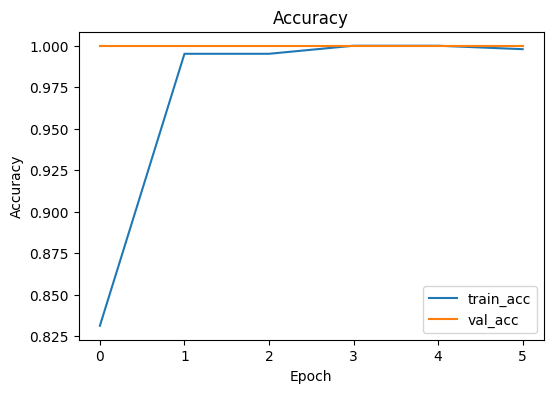

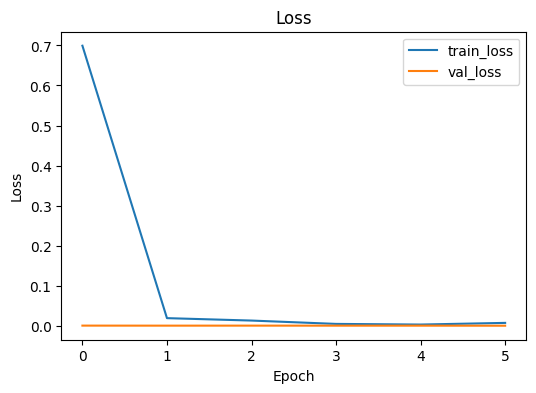

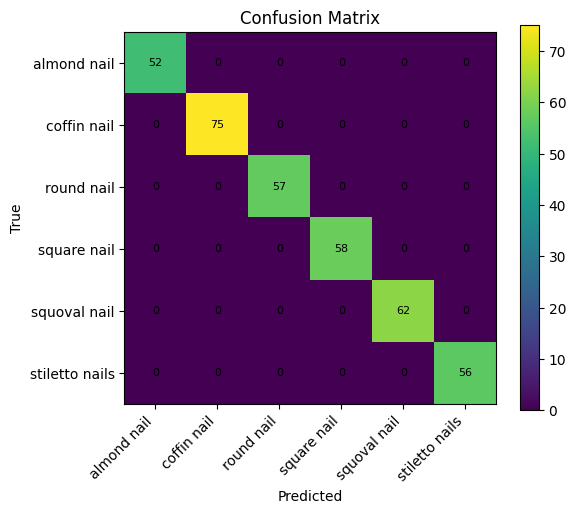

('/content/drive/MyDrive/nail_results_vgg16/accuracy_curve.png',
 '/content/drive/MyDrive/nail_results_vgg16/loss_curve.png',
 '/content/drive/MyDrive/nail_results_vgg16/confusion_matrix.png')

In [ ]:
hist = history.history

plt.figure(figsize=(6,4))
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
acc_png = os.path.join(results_dir, "accuracy_curve.png")
plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
loss_png = os.path.join(results_dir, "loss_curve.png")
plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, class_names, rotation=45, ha="right")
plt.yticks(ticks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
for i, j in itertools.product(range(num_classes), range(num_classes)):
    plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
cm_png = os.path.join(results_dir, "confusion_matrix.png")
plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

(acc_png, loss_png, cm_png)


In [ ]:
counts, samples = [], []
for cname in class_names:
    class_dir = Path(dataset_path)/cname
    files = sorted([p for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp") for p in class_dir.glob(ext)])
    counts.append(len(files))
    samples.append(str(files[0]) if files else "")

dataset_summary_df = pd.DataFrame({
    "Class Name": class_names,
    "Total Images": counts,
    "Sample Image Path": samples
})
dataset_summary_csv = os.path.join(results_dir, "dataset_summary.csv")
dataset_summary_df.to_csv(dataset_summary_csv, index=False)
dataset_summary_df


,Class Name,Total Images,Sample Image Path
0,almond nail,300,/content/drive/MyDrive/nail_dataset/almond nai...
1,coffin nail,300,/content/drive/MyDrive/nail_dataset/coffin nai...
2,round nail,300,/content/drive/MyDrive/nail_dataset/round nail...
3,square nail,300,/content/drive/MyDrive/nail_dataset/square nai...
4,squoval nail,300,/content/drive/MyDrive/nail_dataset/squoval na...
5,stiletto nails,300,/content/drive/MyDrive/nail_dataset/stiletto n...


In [ ]:
metrics_row = {
    "Model": "VGG16",
    "Accuracy": round(float(acc), 4),
    "Precision_macro": round(float(precision_macro), 4),
    "Precision_weighted": round(float(precision_weighted), 4),
    "Loss": round(float(loss), 4),
    "Timestamp": datetime.datetime.now().isoformat(timespec="seconds")
}
metrics_df = pd.DataFrame([metrics_row])
metrics_csv = os.path.join(results_dir, "metrics.csv")
metrics_df.to_csv(metrics_csv, index=False)
metrics_df


,Model,Accuracy,Precision_macro,Precision_weighted,Loss,Timestamp
0,VGG16,1.0,1.0,1.0,0.0003,2025-09-05T18:49:05


In [ ]:
docx_path = os.path.join(results_dir, "VGG16_Results.docx")
doc = Document()

doc.add_heading('VGG16 Results', level=1)

doc.add_heading('Summary Metrics', level=2)
t = doc.add_table(rows=2, cols=4)
hdr = t.rows[0].cells
hdr[0].text, hdr[1].text, hdr[2].text, hdr[3].text = 'Accuracy','Precision (macro)','Precision (weighted)','Loss'
row = t.rows[1].cells
row[0].text = f"{metrics_row['Accuracy']:.4f}"
row[1].text = f"{metrics_row['Precision_macro']:.4f}"
row[2].text = f"{metrics_row['Precision_weighted']:.4f}"
row[3].text = f"{metrics_row['Loss']:.4f}"

doc.add_paragraph()
doc.add_heading('Training Curves & Confusion Matrix', level=2)
for p in [os.path.join(results_dir,"accuracy_curve.png"),
          os.path.join(results_dir,"loss_curve.png"),
          os.path.join(results_dir,"confusion_matrix.png")]:
    if os.path.exists(p):
        doc.add_picture(p, width=Inches(5.5))

doc.add_paragraph()
doc.add_heading('Classification Report (CSV attached)', level=2)
doc.add_paragraph(Path(report_csv).name)

doc.add_heading('Dataset Summary', level=2)
t2 = doc.add_table(rows=1+len(dataset_summary_df), cols=3)
t2.rows[0].cells[0].text = 'Class Name'
t2.rows[0].cells[1].text = 'Total Images'
t2.rows[0].cells[2].text = 'Sample Image'
for i, r in dataset_summary_df.iterrows():
    t2.rows[i+1].cells[0].text = str(r['Class Name'])
    t2.rows[i+1].cells[1].text = str(r['Total Images'])
    t2.rows[i+1].cells[2].text = Path(str(r['Sample Image Path'])).name if r['Sample Image Path'] else "-"

doc.add_paragraph()
doc.add_paragraph("Attached files:")
for p in [metrics_csv, report_csv, cm_csv, dataset_summary_csv]:
    doc.add_paragraph("- " + Path(p).name)

doc.save(docx_path)
docx_path


'/content/drive/MyDrive/nail_results_vgg16/VGG16_Results.docx'

In [7]:
# يساعدنا نعيد تحميل الداتاست مع أي preprocess تختارينه
def make_datasets(dataset_path, img_size, batch_size, seed, preprocess_fn):
    AUTOTUNE = tf.data.AUTOTUNE
    train_raw = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path, validation_split=0.2, subset="training",
        seed=seed, image_size=img_size, batch_size=batch_size
    )
    val_raw = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path, validation_split=0.2, subset="validation",
        seed=seed, image_size=img_size, batch_size=batch_size
    )
    class_names = train_raw.class_names
    num_classes = len(class_names)
    train_ds = (train_raw.map(lambda x,y: (preprocess_fn(x), y), num_parallel_calls=AUTOTUNE)
                        .cache().shuffle(1000).prefetch(AUTOTUNE))
    val_ds   = (val_raw.map(lambda x,y: (preprocess_fn(x), y), num_parallel_calls=AUTOTUNE)
                        .cache().prefetch(AUTOTUNE))
    return train_ds, val_ds, class_names, num_classes


In [11]:
def evaluate_and_report(model, history, MODEL_NAME, results_dir,
                        val_ds, class_names, num_classes,
                        BATCH_SIZE, dataset_path):
    import numpy as np, pandas as pd, datetime, itertools, os
    import matplotlib.pyplot as plt
    from pathlib import Path
    from sklearn.metrics import classification_report, confusion_matrix, precision_score
    from docx import Document
    from docx.shared import Inches
    import tensorflow as tf

    # جمع بيانات الفالديشن
    val_images, val_labels = [], []
    for bx, by in val_ds:
        val_images.append(bx.numpy()); val_labels.append(by.numpy())
    val_images = np.concatenate(val_images, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)

    # تنبؤات ومقاييس
    probs  = model.predict(val_images, batch_size=BATCH_SIZE, verbose=0)
    y_pred = probs.argmax(axis=1)
    acc  = (y_pred == val_labels).mean()
    loss = tf.keras.losses.sparse_categorical_crossentropy(val_labels, probs).numpy().mean()
    precision_macro    = precision_score(val_labels, y_pred, average="macro", zero_division=0)
    precision_weighted = precision_score(val_labels, y_pred, average="weighted", zero_division=0)
    print({"Accuracy": round(float(acc),4),
           "Loss": round(float(loss),4),
           "Precision_macro": round(float(precision_macro),4),
           "Precision_weighted": round(float(precision_weighted),4)})

    # تقارير CSV
    report_df = pd.DataFrame(classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)).transpose()
    report_csv = os.path.join(results_dir, "classification_report.csv")
    report_df.to_csv(report_csv)

    cm = confusion_matrix(val_labels, y_pred, labels=range(num_classes))
    cm_csv = os.path.join(results_dir, "confusion_matrix.csv")
    np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")

    # منحنيات التدريب + مصفوفة الالتباس (صور)
    hist = history.history
    acc_png  = os.path.join(results_dir, "accuracy_curve.png")
    loss_png = os.path.join(results_dir, "loss_curve.png")
    cm_png   = os.path.join(results_dir, "confusion_matrix.png")

    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
    plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
    plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()

    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix"); plt.colorbar()
    ticks = np.arange(num_classes)
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i, j in itertools.product(range(num_classes), range(num_classes)):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
    plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

    # ملخص الداتا (عدد الصور + عينة)
    counts, samples = [], []
    for cname in class_names:
        class_dir = Path(dataset_path) / cname
        files = sorted([p for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp") for p in class_dir.glob(ext)])
        counts.append(len(files))
        samples.append(str(files[0]) if files else "")
    dataset_summary_df = pd.DataFrame({"Class Name": class_names, "Total Images": counts, "Sample Image Path": samples})
    dataset_summary_csv = os.path.join(results_dir, "dataset_summary.csv")
    dataset_summary_df.to_csv(dataset_summary_csv, index=False)

    # حفظ صف المقاييس المختصر + Word
    metrics_row = {
        "Model": MODEL_NAME,
        "Accuracy": round(float(acc), 4),
        "Precision_macro": round(float(precision_macro), 4),
        "Precision_weighted": round(float(precision_weighted), 4),
        "Loss": round(float(loss), 4),
        "Timestamp": datetime.datetime.now().isoformat(timespec="seconds")
    }
    metrics_df = pd.DataFrame([metrics_row])
    metrics_csv = os.path.join(results_dir, "metrics.csv")
    metrics_df.to_csv(metrics_csv, index=False)

    docx_path = os.path.join(results_dir, f"{MODEL_NAME}_Results.docx")
    doc = Document()
    doc.add_heading(f'{MODEL_NAME} Results', 1)

    # جدول المقاييس
    doc.add_heading('Summary Metrics', level=2)
    t = doc.add_table(rows=2, cols=4)
    hdr = t.rows[0].cells
    hdr[0].text, hdr[1].text, hdr[2].text, hdr[3].text = 'Accuracy','Precision (macro)','Precision (weighted)','Loss'
    row = t.rows[1].cells
    row[0].text = f"{metrics_row['Accuracy']:.4f}"
    row[1].text = f"{metrics_row['Precision_macro']:.4f}"
    row[2].text = f"{metrics_row['Precision_weighted']:.4f}"
    row[3].text = f"{metrics_row['Loss']:.4f}"

    doc.add_paragraph()
    doc.add_heading('Training Curves & Confusion Matrix', level=2)
    for p in [acc_png, loss_png, cm_png]:
        if os.path.exists(p):
            doc.add_picture(p, width=Inches(5.5))

    doc.add_paragraph()
    doc.add_heading('Classification Report (CSV attached)', level=2)
    doc.add_paragraph(Path(report_csv).name)

    doc.add_heading('Dataset Summary', level=2)
    t2 = doc.add_table(rows=1+len(dataset_summary_df), cols=3)
    t2.rows[0].cells[0].text = 'Class Name'
    t2.rows[0].cells[1].text = 'Total Images'
    t2.rows[0].cells[2].text = 'Sample Image'
    for i, r in dataset_summary_df.iterrows():
        t2.rows[i+1].cells[0].text = str(r['Class Name'])
        t2.rows[i+1].cells[1].text = str(r['Total Images'])
        t2.rows[i+1].cells[2].text = Path(str(r['Sample Image Path'])).name if r['Sample Image Path'] else "-"

    doc.add_paragraph()
    doc.add_paragraph("Attachments in folder:")
    for p in [metrics_csv, report_csv, cm_csv, dataset_summary_csv]:
        doc.add_paragraph("- " + Path(p).name)

    doc.save(docx_path)
    print("Saved Word:", docx_path)


## **VGG19**

In [ ]:
from tensorflow.keras.applications import VGG19

MODEL_NAME = "VGG19"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

# نفس preprocessing تبع VGG
preprocess = tf.keras.applications.vgg19.preprocess_input
train_ds, val_ds, class_names, num_classes = make_datasets(
    dataset_path, IMG_SIZE, BATCH_SIZE, SEED, preprocess
)

# بناء الرأس + التدريب
base_model = VGG19(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
base_model.trainable = False
inputs = layers.Input(shape=IMG_SIZE+(3,))
x = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, mode="max", verbose=1),
    CSVLogger(csv_log)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

# —— تشغيل باقة 6→10 (انسخي نفس حزمة التقييم والـ Word اللي عطيتك قبل، أو شغّليها مباشرة إنكِ محتفظة فيها)


Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.5774 - loss: 1.9468 
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/nail_results_vgg19/best_vgg19.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1271s 28s/step - accuracy: 0.5823 - loss: 1.9221 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9863 - loss: 0.0451 
Epoch 2: val_accuracy did not improve from 1.00000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1240s 28s/step - accuracy: 0.9864 - loss: 0.0449 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9879 - loss: 0.0320 
Epoch 3: val_accuracy did not improve from 1.00000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1254s 28s/step - accuracy: 0.9881 - loss: 0.0317 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 4/10
45/45

{'Accuracy': 1.0, 'Loss': 0.0025, 'Precision_macro': 1.0, 'Precision_weighted': 1.0}


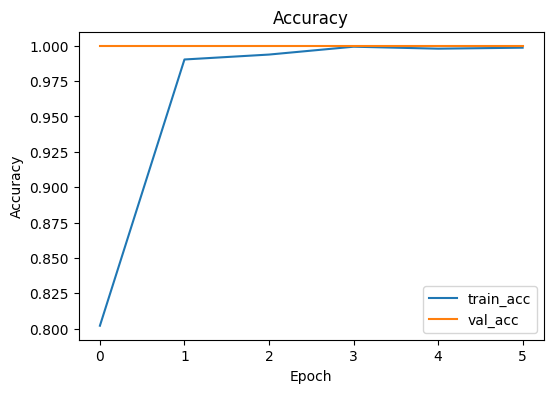

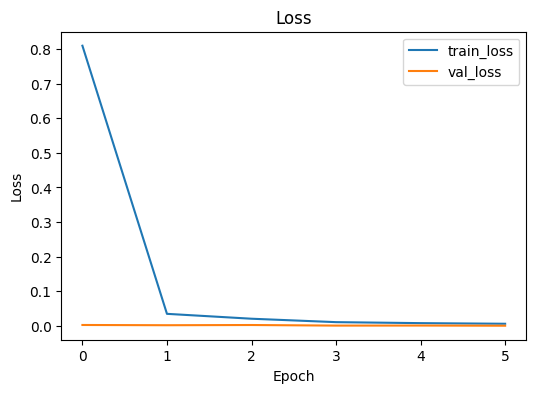

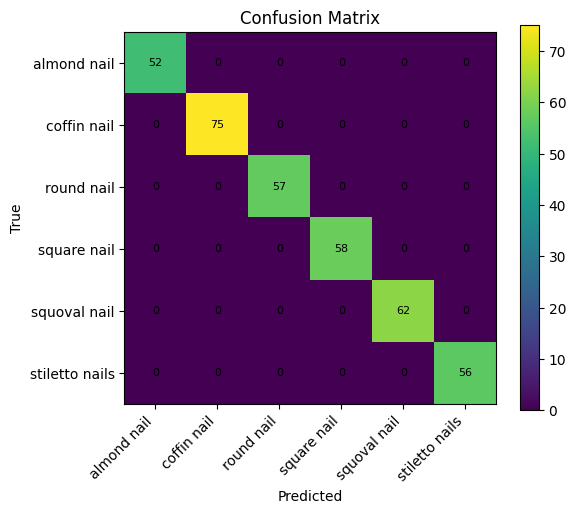

Saved Word: /content/drive/MyDrive/nail_results_vgg19/VGG19_Results.docx


In [ ]:
evaluate_and_report(model, history, MODEL_NAME, results_dir,
                    val_ds, class_names, num_classes,
                    BATCH_SIZE, dataset_path)


## **ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50

MODEL_NAME = "ResNet50"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

preprocess = tf.keras.applications.resnet.preprocess_input
train_ds, val_ds, class_names, num_classes = make_datasets(dataset_path, IMG_SIZE, BATCH_SIZE, SEED, preprocess)

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
base_model.trainable = False
inputs = layers.Input(shape=IMG_SIZE+(3,))
x = layers.RandomFlip("horizontal")(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
    CSVLogger(csv_log)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)


Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8170 - loss: 0.5922
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/nail_results_resnet50/best_resnet50.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 351s 7s/step - accuracy: 0.8198 - loss: 0.5834 - val_accuracy: 1.0000 - val_loss: 2.7838e-04
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 1.0000 - loss: 0.0029
Epoch 2: val_accuracy did not improve from 1.00000
45/45 ━━━━━━━━━━━━━━━━━━━━ 352s 7s/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 9.5266e-05
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 1.0000 - loss: 0.0024
Epoch 3: val_accuracy did not improve from 1.00000
45/45 ━━━━━━━━━━━━━━━━━━━━ 344s 8s/step - accuracy: 1.0000 - loss: 0.0024 - val

{'Accuracy': 1.0, 'Loss': 0.0003, 'Precision_macro': 1.0, 'Precision_weighted': 1.0}


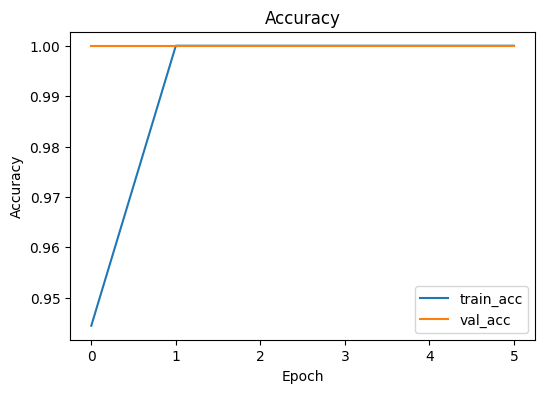

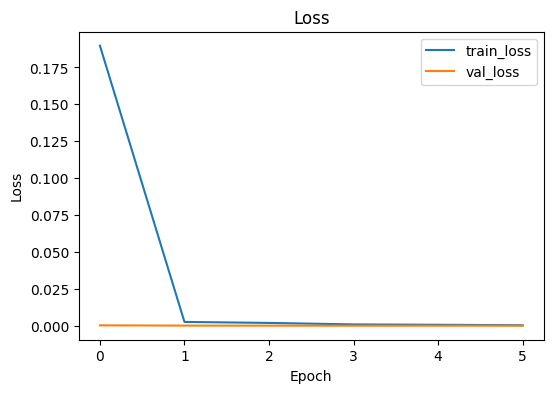

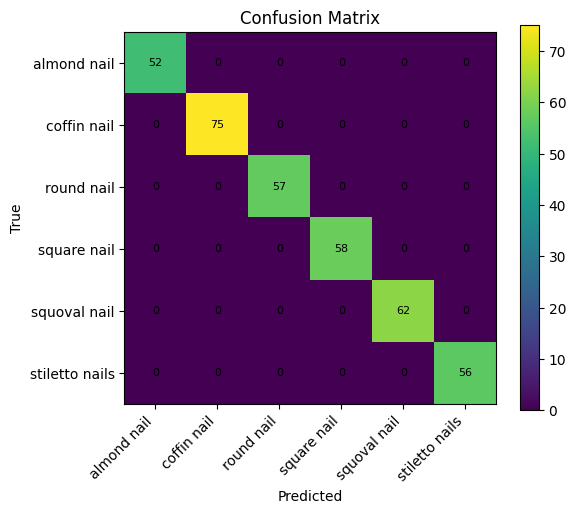

Saved Word: /content/drive/MyDrive/nail_results_resnet50/ResNet50_Results.docx


In [ ]:
evaluate_and_report(model, history, MODEL_NAME, results_dir,
                    val_ds, class_names, num_classes,
                    BATCH_SIZE, dataset_path)


## **ResNet101**

In [ ]:
from tensorflow.keras.applications import ResNet101

MODEL_NAME = "ResNet101"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

preprocess = tf.keras.applications.resnet.preprocess_input
train_ds, val_ds, class_names, num_classes = make_datasets(dataset_path, IMG_SIZE, BATCH_SIZE, SEED, preprocess)

base_model = ResNet101(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
base_model.trainable = False
inputs = layers.Input(shape=IMG_SIZE+(3,))
x = layers.RandomFlip("horizontal")(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
    CSVLogger(csv_log)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)


Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7968 - loss: 0.7463 
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/nail_results_resnet101/best_resnet101.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 613s 13s/step - accuracy: 0.7997 - loss: 0.7354 - val_accuracy: 1.0000 - val_loss: 7.2165e-04
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 1.0000 - loss: 0.0034
Epoch 2: val_accuracy did not improve from 1.00000
45/45 ━━━━━━━━━━━━━━━━━━━━ 556s 12s/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 1.8511e-04
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 1.0000 - loss: 0.0014
Epoch 3: val_accuracy did not improve from 1.00000
45/45 ━━━━━━━━━━━━━━━━━━━━ 555s 12s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 1.1184e-04
E

{'Accuracy': 1.0, 'Loss': 0.0007, 'Precision_macro': 1.0, 'Precision_weighted': 1.0}


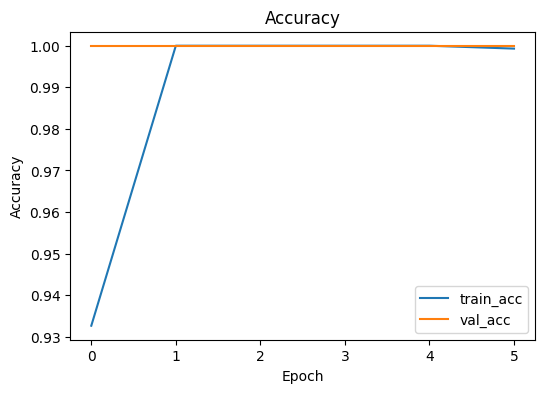

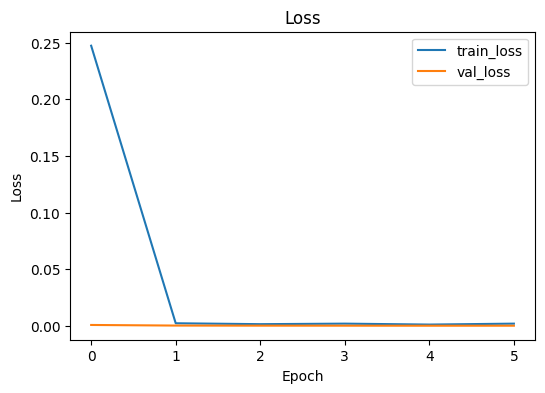

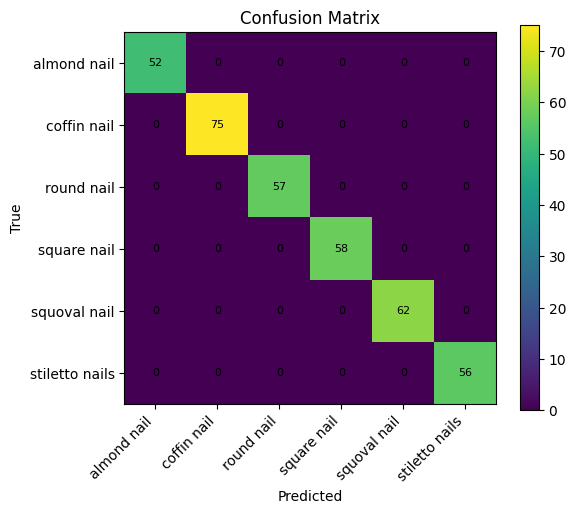

Saved Word: /content/drive/MyDrive/nail_results_resnet101/ResNet101_Results.docx


In [ ]:
evaluate_and_report(model, history, MODEL_NAME, results_dir,
                    val_ds, class_names, num_classes,
                    BATCH_SIZE, dataset_path)


## **ViT-B16**

In [1]:
# ===================== تنصيب الحزم =====================
!pip -q install timm python-docx tqdm

# ===================== الاستيراد =====================
import os, gc, math, random, glob
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from PIL import ImageFile
import timm
from tqdm import tqdm

# في حال وجود صور ناقصة
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ===================== إعدادات عامة =====================
img_size    = 224
batch_size  = 16   # خفيف على كولاب
num_epochs  = 10
seed        = 42
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed)
random.seed(seed)

if device.type == "cuda":
    torch.cuda.manual_seed_all(seed)

# ===================== Google Drive =====================
from google.colab import drive
drive.mount('/content/drive')

# مسار بياناتك (كل فئة داخل مجلد باسمها)
dataset_path = '/content/drive/MyDrive/nail_dataset'

# مجلد النتائج
results_dir = "/content/drive/MyDrive/nail_results_vit_b16_torch"
os.makedirs(results_dir, exist_ok=True)
best_path = os.path.join(results_dir, "best_vit_b16_torch.pt")

# ===================== التحويلات =====================
train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ===================== تحميل البيانات =====================
full_ds = datasets.ImageFolder(root=dataset_path, transform=train_tf)  # نفس التحويل للتقسيم
num_samples = len(full_ds.samples)
indices     = torch.randperm(num_samples)
split       = int(0.8 * num_samples)
train_idx   = indices[:split]
val_idx     = indices[split:]

# نستخدم تحويليْن مختلفيْن للتدريب/التحقق
train_base = datasets.ImageFolder(root=dataset_path, transform=train_tf)
val_base   = datasets.ImageFolder(root=dataset_path, transform=val_tf)

train_ds = Subset(train_base, train_idx)
val_ds   = Subset(val_base,   val_idx)

class_names = train_base.classes
num_classes = len(class_names)
print(f"Found {num_samples} images in {num_classes} classes:", class_names)

loader_kwargs = dict(
    batch_size=batch_size,
    pin_memory=(device.type=="cuda"),
    num_workers=0,
    persistent_workers=False
)
train_loader = DataLoader(train_ds, shuffle=True,  drop_last=False, **loader_kwargs)
val_loader   = DataLoader(val_ds,   shuffle=False, drop_last=False, **loader_kwargs)

# ===================== الموديل =====================
# لو الذاكرة ضعيفة بدّلي إلى: 'vit_tiny_patch16_224'
model_name = 'vit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

# ===================== التدريب =====================
train_acc_hist, train_loss_hist = [], []
val_acc_hist,   val_loss_hist   = [], []

best_val_acc = 0.0

for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total   += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=float(loss.item()), acc=float(correct/max(total,1)))

    train_loss = running_loss / max(len(train_loader),1)
    train_acc  = correct / max(total,1)
    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)

    # ---- Validate ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.inference_mode():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total   += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= max(len(val_loader),1)
    val_acc   = val_correct / max(val_total,1)
    val_acc_hist.append(val_acc)
    val_loss_hist.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} - "
          f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

    # حفظ أفضل نموذج
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "state_dict": model.state_dict(),
            "class_names": class_names,
            "model_name": model_name,
            "img_size": img_size
        }, best_path)
        print(f"✅ Saved best model to: {best_path} (val_acc={best_val_acc:.4f})")

    # تفريغ الذاكرة
    if device.type == "cuda":
        torch.cuda.empty_cache()
    gc.collect()

print("⚡️ Training done. Best Val Acc:", best_val_acc)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 9.2 MB/s eta 0:00:00
Mounted at /content/drive
Found 1800 images in 6 classes: ['almond nail', 'coffin nail', 'round nail', 'square nail', 'squoval nail', 'stiletto nails']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/tmp/ipython-input-3815398770.py:95: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
Epoch 1/10:   0%|          | 0/90 [00:00<?, ?it/s]/tmp/ipython-input-3815398770.py:113: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-3815398770.py:139: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 1/10 - Train Acc: 0.9611, Train Loss: 0.1176 - Val Acc: 1.0000, Val Loss: 0.0001
✅ Saved best model to: /content/drive/MyDrive/nail_results_vit_b16_torch/best_vit_b16_torch.pt (val_acc=1.0000)


Epoch 2/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 3/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 4/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 5/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 6/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 7/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 8/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 9/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000


Epoch 10/10 - Train Acc: 1.0000, Train Loss: 0.0000 - Val Acc: 1.0000, Val Loss: 0.0000
⚡️ Training done. Best Val Acc: 1.0


{'Accuracy': 1.0, 'Loss': 0.0, 'Precision_macro': 1.0, 'Precision_weighted': 1.0}


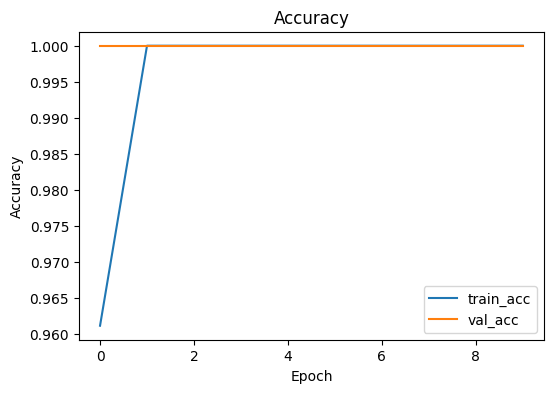

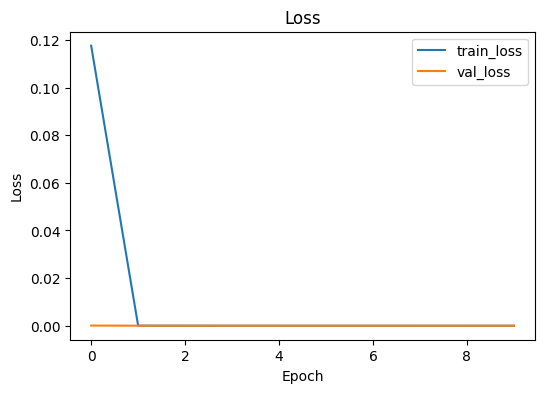

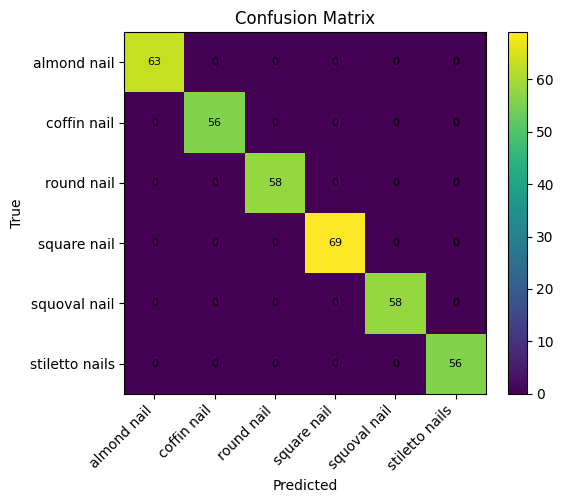

Saved Word: /content/drive/MyDrive/nail_results_vit_b16_torch/ViT_B16_timm_Results.docx
Folder: /content/drive/MyDrive/nail_results_vit_b16_torch


In [2]:
# ===================== التقييم والتقارير =====================
import numpy as np, pandas as pd, itertools
from sklearn.metrics import classification_report, confusion_matrix, precision_score
import matplotlib.pyplot as plt
from docx import Document
from docx.shared import Inches
from pathlib import Path

# ---- تنبؤات الفالديشن ----
model.eval()
all_probs, all_preds, all_labels = [], [], []

with torch.inference_mode():
    for images, labels in val_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = probs.argmax(axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

y_prob  = np.concatenate(all_probs, axis=0)
y_pred  = np.concatenate(all_preds, axis=0)
y_true  = np.concatenate(all_labels, axis=0)

# ---- مقاييس أساسية ----
acc = (y_pred == y_true).mean()
# Loss المتوسط على الفالديشن حسب CrossEntropy (تقريب باستخدام الـ logits السابقة)
# (عندنا val_loss_hist من حلقة التدريب، نأخذ آخر قيمة)
loss = float(val_loss_hist[-1]) if len(val_loss_hist)>0 else float("nan")
precision_macro    = precision_score(y_true, y_pred, average="macro",    zero_division=0)
precision_weighted = precision_score(y_true, y_pred, average="weighted", zero_division=0)

print({
    "Accuracy": round(float(acc),4),
    "Loss": round(float(loss),4),
    "Precision_macro": round(float(precision_macro),4),
    "Precision_weighted": round(float(precision_weighted),4),
})

# ---- Classification Report + Confusion Matrix (CSV) ----
report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True)).transpose()
report_csv = os.path.join(results_dir, "classification_report.csv")
report_df.to_csv(report_csv)

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
cm_csv = os.path.join(results_dir, "confusion_matrix.csv")
np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")

# ---- منحنيات التدريب ----
acc_png  = os.path.join(results_dir, "accuracy_curve.png")
loss_png = os.path.join(results_dir, "loss_curve.png")
cm_png   = os.path.join(results_dir, "confusion_matrix.png")

plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="train_acc")
plt.plot(val_acc_hist,   label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label="train_loss")
plt.plot(val_loss_hist,   label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, class_names, rotation=45, ha="right")
plt.yticks(ticks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
for i, j in itertools.product(range(num_classes), range(num_classes)):
    plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

# ---- Dataset Summary (counts + sample image) ----
def list_images(folder):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(folder, e)))
    return sorted(files)

counts, samples = [], []
for cname in class_names:
    cdir = os.path.join(dataset_path, cname)
    files = list_images(cdir)
    counts.append(len(files))
    samples.append(files[0] if files else "")

dataset_summary_df = pd.DataFrame({
    "Class Name": class_names,
    "Total Images": counts,
    "Sample Image Path": samples
})
dataset_summary_csv = os.path.join(results_dir, "dataset_summary.csv")
dataset_summary_df.to_csv(dataset_summary_csv, index=False)

# ---- حفظ صف المقاييس المختصر + Word ----
metrics_row = {
    "Model": "ViT_B16_timm",
    "Accuracy": round(float(acc), 4),
    "Precision_macro": round(float(precision_macro), 4),
    "Precision_weighted": round(float(precision_weighted), 4),
    "Loss": round(float(loss), 4),
}
metrics_df = pd.DataFrame([metrics_row])
metrics_csv = os.path.join(results_dir, "metrics.csv")
metrics_df.to_csv(metrics_csv, index=False)

docx_path = os.path.join(results_dir, "ViT_B16_timm_Results.docx")
doc = Document()
doc.add_heading('ViT-B16 (timm) Results', level=1)

doc.add_heading('Summary Metrics', level=2)
t = doc.add_table(rows=2, cols=4)
hdr = t.rows[0].cells
hdr[0].text, hdr[1].text, hdr[2].text, hdr[3].text = 'Accuracy','Precision (macro)','Precision (weighted)','Loss'
row = t.rows[1].cells
row[0].text = f"{metrics_row['Accuracy']:.4f}"
row[1].text = f"{metrics_row['Precision_macro']:.4f}"
row[2].text = f"{metrics_row['Precision_weighted']:.4f}"
row[3].text = f"{metrics_row['Loss']:.4f}"

doc.add_paragraph()
doc.add_heading('Training Curves & Confusion Matrix', level=2)
for p in [acc_png, loss_png, cm_png]:
    if os.path.exists(p): doc.add_picture(p, width=Inches(5.5))

doc.add_paragraph()
doc.add_heading('Classification Report (CSV attached)', level=2)
doc.add_paragraph(Path(report_csv).name)

doc.add_heading('Dataset Summary', level=2)
t2 = doc.add_table(rows=1+len(dataset_summary_df), cols=3)
t2.rows[0].cells[0].text = 'Class Name'
t2.rows[0].cells[1].text = 'Total Images'
t2.rows[0].cells[2].text = 'Sample Image'
for i, r in dataset_summary_df.iterrows():
    t2.rows[i+1].cells[0].text = str(r['Class Name'])
    t2.rows[i+1].cells[1].text = str(r['Total Images'])
    t2.rows[i+1].cells[2].text = Path(str(r['Sample Image Path'])).name if r['Sample Image Path'] else "-"

doc.add_paragraph()
doc.add_paragraph("Attachments in folder:")
for p in [metrics_csv, report_csv, cm_csv, dataset_summary_csv]:
    doc.add_paragraph("- " + Path(p).name)

doc.save(docx_path)
print("Saved Word:", docx_path)
print("Folder:", results_dir)


## **SelfCNN — 3 Conv / 3 Pool / 3 Dense**

Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1589 - loss: 1.8443 
Epoch 1: val_accuracy improved from -inf to 0.15556, saving model to /content/drive/MyDrive/nail_results_selfcnn_3conv/best_selfcnn_3conv.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 562s 12s/step - accuracy: 0.1590 - loss: 1.8435 - val_accuracy: 0.1556 - val_loss: 1.7918
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1807 - loss: 1.7962 
Epoch 2: val_accuracy did not improve from 0.15556
45/45 ━━━━━━━━━━━━━━━━━━━━ 501s 11s/step - accuracy: 0.1806 - loss: 1.7961 - val_accuracy: 0.1444 - val_loss: 1.7933
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1610 - loss: 1.7916 
Epoch 3: val_accuracy improved from 0.15556 to 0.45556, saving model to /content/drive/MyDrive/nail_results_selfcnn_3conv/best_selfcnn_3conv.keras
45/45 ━━━━━━━━━━━━━━━━━━

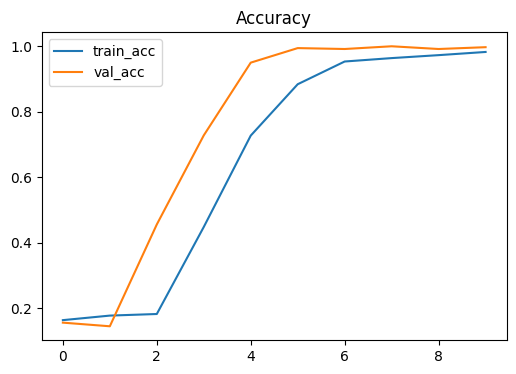

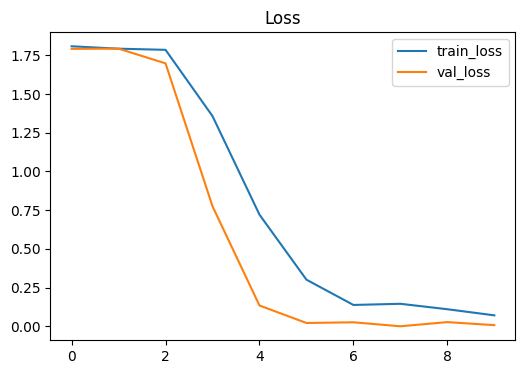

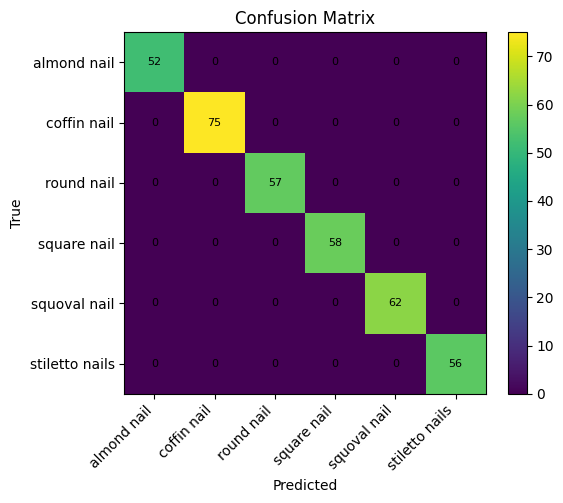

Saved: /content/drive/MyDrive/nail_results_selfcnn_3conv/SelfCNN_3conv_Results.docx 
Folder: /content/drive/MyDrive/nail_results_selfcnn_3conv


In [14]:
# ==== إعدادات سريعة (تتأكد إن المتغيرات موجودة) ====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, itertools, glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from docx import Document
from docx.shared import Inches
from pathlib import Path

# مسار الداتا
dataset_path = globals().get("dataset_path", "/content/drive/MyDrive/nail_dataset")
IMG_SIZE     = globals().get("IMG_SIZE", (224,224))
BATCH_SIZE   = globals().get("BATCH_SIZE", 32)
SEED         = globals().get("SEED", 123)

MODEL_NAME  = "SelfCNN_3conv"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

# ==== دالة بناء الموديل ====
def build_self_cnn(img_size, num_classes, num_conv_blocks=3, base_filters=32, dense_units=(256,128,64)):
    inputs = layers.Input(shape=img_size+(3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    filters = base_filters
    for _ in range(num_conv_blocks):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        filters = min(filters*2, 256)
    x = layers.Flatten()(x)
    for u in dense_units:
        x = layers.Dense(u, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs, name=f"SelfCNN_{num_conv_blocks}conv")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# ==== تحميل البيانات (بدون preprocess خارجي لأن الموديل يعمل Rescaling داخليًا) ====
AUTOTUNE = tf.data.AUTOTUNE
train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path, validation_split=0.2, subset="training",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path, validation_split=0.2, subset="validation",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
class_names = train_raw.class_names
num_classes = len(class_names)
train_ds = train_raw.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_raw.cache().prefetch(AUTOTUNE)

# ==== بناء + تدريب ====
model = build_self_cnn(IMG_SIZE, num_classes, num_conv_blocks=3, base_filters=32, dense_units=(256,128,64))
ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, mode="max", verbose=1),
    tf.keras.callbacks.CSVLogger(csv_log),
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

# ==== التقييم + الحفظ ====
# تجميع صور/ليبلات الفالديشن
val_images, val_labels = [], []
for bx, by in val_ds:
    val_images.append(bx.numpy()); val_labels.append(by.numpy())
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

probs  = model.predict(val_images, batch_size=BATCH_SIZE, verbose=0)
y_pred = probs.argmax(axis=1)
acc  = (y_pred == val_labels).mean()
loss = tf.keras.losses.sparse_categorical_crossentropy(val_labels, probs).numpy().mean()
precision_macro    = precision_score(val_labels, y_pred, average="macro",    zero_division=0)
precision_weighted = precision_score(val_labels, y_pred, average="weighted", zero_division=0)

# CSVs
report_df = pd.DataFrame(classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)).transpose()
report_csv = os.path.join(results_dir, "classification_report.csv"); report_df.to_csv(report_csv)
cm = confusion_matrix(val_labels, y_pred, labels=range(num_classes))
cm_csv = os.path.join(results_dir, "confusion_matrix.csv"); np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")

# المنحنيات
hist = history.history
acc_png  = os.path.join(results_dir, "accuracy_curve.png")
loss_png = os.path.join(results_dir, "loss_curve.png")
cm_png   = os.path.join(results_dir, "confusion_matrix.png")

plt.figure(figsize=(6,4)); plt.plot(hist["accuracy"], label="train_acc"); plt.plot(hist["val_accuracy"], label="val_acc"); plt.legend(); plt.title("Accuracy"); plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()
plt.figure(figsize=(6,4)); plt.plot(hist["loss"], label="train_loss"); plt.plot(hist["val_loss"], label="val_loss"); plt.legend(); plt.title("Loss"); plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()

plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation='nearest'); plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(num_classes); plt.xticks(ticks, class_names, rotation=45, ha="right"); plt.yticks(ticks, class_names)
for i, j in itertools.product(range(num_classes), range(num_classes)): plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

# ملخص الداتا (عدد الصور + مثال)
def list_images(folder):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp"); files=[]
    for e in exts: files.extend(glob.glob(os.path.join(folder, e)))
    return sorted(files)
counts, samples = [], []
for cname in class_names:
    cdir = os.path.join(dataset_path, cname)
    files = list_images(cdir); counts.append(len(files)); samples.append(files[0] if files else "")
dataset_summary_df = pd.DataFrame({"Class Name": class_names, "Total Images": counts, "Sample Image Path": samples})
dataset_summary_csv = os.path.join(results_dir, "dataset_summary.csv"); dataset_summary_df.to_csv(dataset_summary_csv, index=False)

# Word
docx_path = os.path.join(results_dir, f"{MODEL_NAME}_Results.docx")
doc = Document(); doc.add_heading(f'{MODEL_NAME} Results', 1)
t = doc.add_table(rows=2, cols=4); hdr=t.rows[0].cells
hdr[0].text, hdr[1].text, hdr[2].text, hdr[3].text='Accuracy','Precision (macro)','Precision (weighted)','Loss'
row=t.rows[1].cells
row[0].text=f"{acc:.4f}"; row[1].text=f"{precision_macro:.4f}"; row[2].text=f"{precision_weighted:.4f}"; row[3].text=f"{loss:.4f}"
for p in [acc_png, loss_png, cm_png]:
    if os.path.exists(p): doc.add_picture(p, width=Inches(5.5))
doc.add_paragraph("Files:");
for p in [dataset_summary_csv, report_csv, cm_csv, csv_log]: doc.add_paragraph("- "+Path(p).name)
doc.save(docx_path)
print("Saved:", docx_path, "\nFolder:", results_dir)


## **SelfCNN — 5 Conv / 5 Pool / 3 Dense**

Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.1559 - loss: 1.8026 
Epoch 1: val_accuracy improved from -inf to 0.15833, saving model to /content/drive/MyDrive/nail_results_selfcnn_5conv/best_selfcnn_5conv.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 669s 15s/step - accuracy: 0.1558 - loss: 1.8025 - val_accuracy: 0.1583 - val_loss: 1.7933
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.1897 - loss: 1.7915 
Epoch 2: val_accuracy did not improve from 0.15833
45/45 ━━━━━━━━━━━━━━━━━━━━ 648s 14s/step - accuracy: 0.1896 - loss: 1.7915 - val_accuracy: 0.1444 - val_loss: 1.7937
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.1823 - loss: 1.7910 
Epoch 3: val_accuracy did not improve from 0.15833
45/45 ━━━━━━━━━━━━━━━━━━━━ 689s 15s/step - accuracy: 0.1822 - loss: 1.7910 - val_accuracy: 0.1444 - val_loss: 1.7937
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


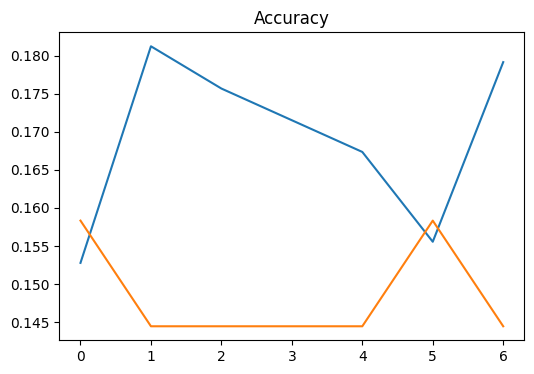

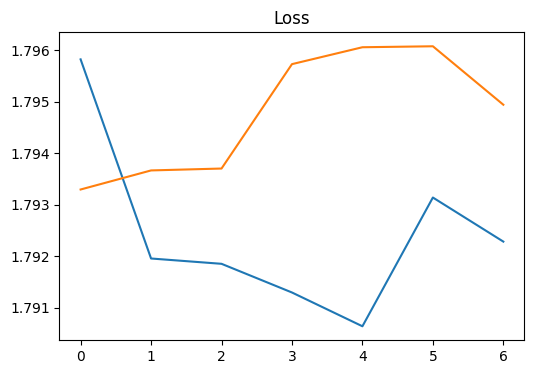

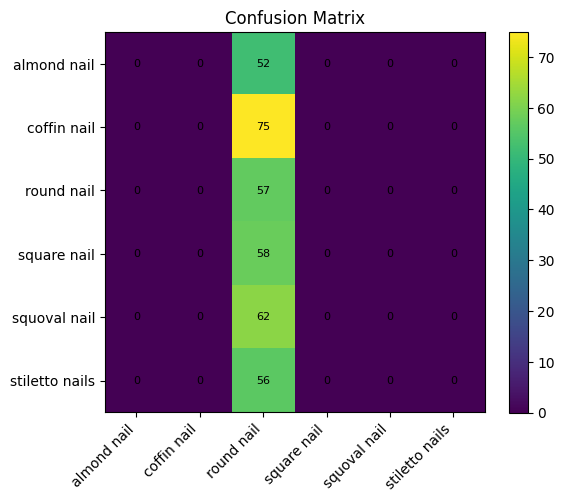

Saved: /content/drive/MyDrive/nail_results_selfcnn_5conv/SelfCNN_5conv_Results.docx 
Folder: /content/drive/MyDrive/nail_results_selfcnn_5conv


In [15]:
# ==== إعدادات ====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, itertools, glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from docx import Document
from docx.shared import Inches
from pathlib import Path

dataset_path = globals().get("dataset_path", "/content/drive/MyDrive/nail_dataset")
IMG_SIZE     = globals().get("IMG_SIZE", (224,224))
BATCH_SIZE   = globals().get("BATCH_SIZE", 32)
SEED         = globals().get("SEED", 123)

MODEL_NAME  = "SelfCNN_5conv"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

def build_self_cnn(img_size, num_classes, num_conv_blocks=5, base_filters=32, dense_units=(256,128,64)):
    inputs = layers.Input(shape=img_size+(3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    filters = base_filters
    for _ in range(num_conv_blocks):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        filters = min(filters*2, 256)
    x = layers.Flatten()(x)
    for u in dense_units:
        x = layers.Dense(u, activation="relu")(x); x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs, name=f"SelfCNN_{num_conv_blocks}conv")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

AUTOTUNE = tf.data.AUTOTUNE
train_raw = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split=0.2, subset="training",
                                                                seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_raw   = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split=0.2, subset="validation",
                                                                seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
class_names = train_raw.class_names; num_classes=len(class_names)
train_ds = train_raw.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_raw.cache().prefetch(AUTOTUNE)

model = build_self_cnn(IMG_SIZE, num_classes, num_conv_blocks=5, base_filters=32, dense_units=(256,128,64))
ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, mode="max", verbose=1),
    tf.keras.callbacks.CSVLogger(csv_log),
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

# ======= التقييم والحفظ (نفس ما سبق) =======
val_images, val_labels = [], []
for bx, by in val_ds: val_images.append(bx.numpy()); val_labels.append(by.numpy())
val_images = np.concatenate(val_images, 0); val_labels = np.concatenate(val_labels, 0)
probs  = model.predict(val_images, batch_size=BATCH_SIZE, verbose=0); y_pred = probs.argmax(1)
acc  = (y_pred == val_labels).mean()
loss = tf.keras.losses.sparse_categorical_crossentropy(val_labels, probs).numpy().mean()
precision_macro    = precision_score(val_labels, y_pred, average="macro",    zero_division=0)
precision_weighted = precision_score(val_labels, y_pred, average="weighted", zero_division=0)

report_df = pd.DataFrame(classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)).transpose()
report_csv = os.path.join(results_dir, "classification_report.csv"); report_df.to_csv(report_csv)
cm = confusion_matrix(val_labels, y_pred, labels=range(num_classes))
cm_csv = os.path.join(results_dir, "confusion_matrix.csv"); np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")
hist = history.history
acc_png  = os.path.join(results_dir, "accuracy_curve.png")
loss_png = os.path.join(results_dir, "loss_curve.png")
cm_png   = os.path.join(results_dir, "confusion_matrix.png")
plt.figure(figsize=(6,4)); plt.plot(hist["accuracy"]); plt.plot(hist["val_accuracy"]); plt.title("Accuracy"); plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()
plt.figure(figsize=(6,4)); plt.plot(hist["loss"]); plt.plot(hist["val_loss"]); plt.title("Loss"); plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()
plt.figure(figsize=(6,5)); plt.imshow(cm); plt.title("Confusion Matrix"); plt.colorbar();
ticks=np.arange(num_classes); plt.xticks(ticks, class_names, rotation=45, ha="right"); plt.yticks(ticks, class_names)
for i,j in itertools.product(range(num_classes), range(num_classes)): plt.text(j,i,cm[i,j],ha="center",va="center",fontsize=8)
plt.tight_layout(); plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

def list_images(folder):
    exts=("*.jpg","*.jpeg","*.png","*.bmp","*.webp"); files=[];
    for e in exts: files.extend(glob.glob(os.path.join(folder, e)));
    return sorted(files)
counts,samples=[],[]
for cname in class_names:
    cdir=os.path.join(dataset_path,cname); files=list_images(cdir); counts.append(len(files)); samples.append(files[0] if files else "")
dataset_summary_df=pd.DataFrame({"Class Name":class_names,"Total Images":counts,"Sample Image Path":samples})
dataset_summary_csv=os.path.join(results_dir,"dataset_summary.csv"); dataset_summary_df.to_csv(dataset_summary_csv,index=False)

docx_path=os.path.join(results_dir,f"{MODEL_NAME}_Results.docx")
doc=Document(); doc.add_heading(f'{MODEL_NAME} Results',1)
t=doc.add_table(rows=2,cols=4); hdr=t.rows[0].cells; hdr[0].text, hdr[1].text, hdr[2].text, hdr[3].text='Accuracy','Precision (macro)','Precision (weighted)','Loss'
row=t.rows[1].cells; row[0].text=f"{acc:.4f}"; row[1].text=f"{precision_macro:.4f}"; row[2].text=f"{precision_weighted:.4f}"; row[3].text=f"{loss:.4f}"
for p in [acc_png,loss_png,cm_png]:
    if os.path.exists(p): doc.add_picture(p, width=Inches(5.5))
for p in [dataset_summary_csv, report_csv, cm_csv, csv_log]: doc.add_paragraph("- "+Path(p).name)
doc.save(docx_path); print("Saved:", docx_path, "\nFolder:", results_dir)


## **SelfCNN — 7 Conv / 7 Pool / 3 Dense**

Found 1800 files belonging to 6 classes.
Using 1440 files for training.
Found 1800 files belonging to 6 classes.
Using 360 files for validation.
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.1586 - loss: 1.7935 
Epoch 1: val_accuracy improved from -inf to 0.14444, saving model to /content/drive/MyDrive/nail_results_selfcnn_7conv/best_selfcnn_7conv.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 800s 17s/step - accuracy: 0.1585 - loss: 1.7935 - val_accuracy: 0.1444 - val_loss: 1.7934
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.1745 - loss: 1.7912 
Epoch 2: val_accuracy did not improve from 0.14444
45/45 ━━━━━━━━━━━━━━━━━━━━ 756s 17s/step - accuracy: 0.1743 - loss: 1.7912 - val_accuracy: 0.1444 - val_loss: 1.7931
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.1585 - loss: 1.7953 
Epoch 3: val_accuracy did not improve from 0.14444
45/45 ━━━━━━━━━━━━━━━━━━━━ 730s 16s/step - accuracy: 0.1586 - loss: 1.7952 - val_accuracy: 0.1444 - val_loss: 1.7946
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


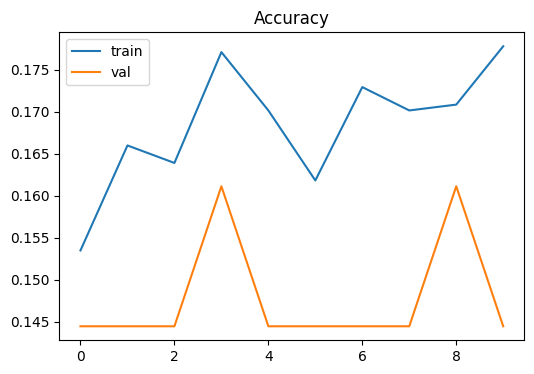

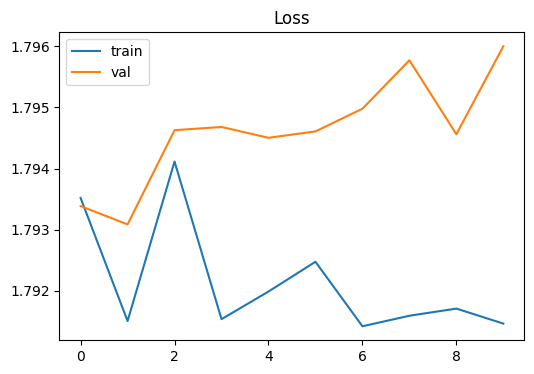

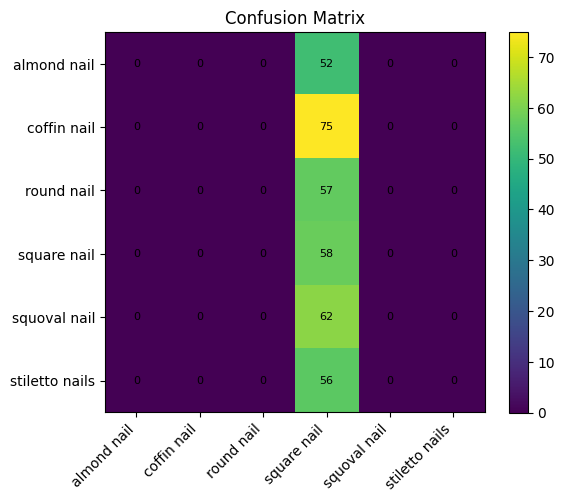

✅ Saved: /content/drive/MyDrive/nail_results_selfcnn_7conv/SelfCNN_7conv_Results.docx 
📂 Folder: /content/drive/MyDrive/nail_results_selfcnn_7conv


In [18]:
# ================= تثبيت الحزم الناقصة =================
!pip install -q python-docx

# ================= الاستيرادات =================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, itertools, glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from docx import Document
from docx.shared import Inches
from pathlib import Path

# ================= إعدادات =================
dataset_path = globals().get("dataset_path", "/content/drive/MyDrive/nail_dataset")
IMG_SIZE     = globals().get("IMG_SIZE", (224,224))
BATCH_SIZE   = globals().get("BATCH_SIZE", 32)
SEED         = globals().get("SEED", 123)

MODEL_NAME  = "SelfCNN_7conv"
results_dir = f"/content/drive/MyDrive/nail_results_{MODEL_NAME.lower()}"
os.makedirs(results_dir, exist_ok=True)

# ================= بناء الموديل =================
def build_self_cnn(img_size, num_classes, num_conv_blocks=7, base_filters=32, dense_units=(256,128,64)):
    inputs = layers.Input(shape=img_size+(3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    filters = base_filters
    for _ in range(num_conv_blocks):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        filters = min(filters*2, 256)
    x = layers.Flatten()(x)
    for u in dense_units:
        x = layers.Dense(u, activation="relu")(x); x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs, name=f"SelfCNN_{num_conv_blocks}conv")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# ================= تحميل البيانات =================
AUTOTUNE = tf.data.AUTOTUNE
train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path, validation_split=0.2, subset="training",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path, validation_split=0.2, subset="validation",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
class_names = train_raw.class_names; num_classes=len(class_names)
train_ds = train_raw.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_raw.cache().prefetch(AUTOTUNE)

# ================= تدريب =================
model = build_self_cnn(IMG_SIZE, num_classes, num_conv_blocks=7, base_filters=32, dense_units=(256,128,64))
ckpt_path = os.path.join(results_dir, f"best_{MODEL_NAME.lower()}.keras")
csv_log   = os.path.join(results_dir, "train_log.csv")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True, mode="max", verbose=1),
    tf.keras.callbacks.CSVLogger(csv_log),
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

# ================= التقييم =================
val_images, val_labels = [], []
for bx, by in val_ds:
    val_images.append(bx.numpy()); val_labels.append(by.numpy())
val_images = np.concatenate(val_images, 0); val_labels = np.concatenate(val_labels, 0)
probs  = model.predict(val_images, batch_size=BATCH_SIZE, verbose=0)
y_pred = probs.argmax(1)

acc  = (y_pred == val_labels).mean()
loss = tf.keras.losses.sparse_categorical_crossentropy(val_labels, probs).numpy().mean()
precision_macro    = precision_score(val_labels, y_pred, average="macro",    zero_division=0)
precision_weighted = precision_score(val_labels, y_pred, average="weighted", zero_division=0)

# ================= الحفظ (CSV/صور/Word) =================
report_df = pd.DataFrame(classification_report(val_labels, y_pred, target_names=class_names, output_dict=True)).transpose()
report_csv = os.path.join(results_dir, "classification_report.csv"); report_df.to_csv(report_csv)

cm = confusion_matrix(val_labels, y_pred, labels=range(num_classes))
cm_csv = os.path.join(results_dir, "confusion_matrix.csv"); np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")

hist = history.history
acc_png  = os.path.join(results_dir, "accuracy_curve.png")
loss_png = os.path.join(results_dir, "loss_curve.png")
cm_png   = os.path.join(results_dir, "confusion_matrix.png")

plt.figure(figsize=(6,4)); plt.plot(hist["accuracy"],label="train"); plt.plot(hist["val_accuracy"],label="val"); plt.legend(); plt.title("Accuracy"); plt.savefig(acc_png, dpi=150, bbox_inches="tight"); plt.show()
plt.figure(figsize=(6,4)); plt.plot(hist["loss"],label="train"); plt.plot(hist["val_loss"],label="val"); plt.legend(); plt.title("Loss"); plt.savefig(loss_png, dpi=150, bbox_inches="tight"); plt.show()
plt.figure(figsize=(6,5)); plt.imshow(cm); plt.title("Confusion Matrix"); plt.colorbar()
ticks=np.arange(num_classes); plt.xticks(ticks,class_names,rotation=45,ha="right"); plt.yticks(ticks,class_names)
for i,j in itertools.product(range(num_classes),range(num_classes)): plt.text(j,i,cm[i,j],ha="center",va="center",fontsize=8)
plt.tight_layout(); plt.savefig(cm_png, dpi=150, bbox_inches="tight"); plt.show()

def list_images(folder):
    exts=("*.jpg","*.jpeg","*.png","*.bmp","*.webp"); files=[]
    for e in exts: files.extend(glob.glob(os.path.join(folder,e)))
    return sorted(files)
counts,samples=[],[]
for cname in class_names:
    cdir=os.path.join(dataset_path,cname); files=list_images(cdir); counts.append(len(files)); samples.append(files[0] if files else "")
dataset_summary_df=pd.DataFrame({"Class Name":class_names,"Total Images":counts,"Sample Image Path":samples})
dataset_summary_csv=os.path.join(results_dir,"dataset_summary.csv"); dataset_summary_df.to_csv(dataset_summary_csv,index=False)

docx_path=os.path.join(results_dir,f"{MODEL_NAME}_Results.docx")
doc=Document(); doc.add_heading(f'{MODEL_NAME} Results',1)
t=doc.add_table(rows=2,cols=4); hdr=t.rows[0].cells
hdr[0].text,hdr[1].text,hdr[2].text,hdr[3].text='Accuracy','Precision (macro)','Precision (weighted)','Loss'
row=t.rows[1].cells; row[0].text=f"{acc:.4f}"; row[1].text=f"{precision_macro:.4f}"; row[2].text=f"{precision_weighted:.4f}"; row[3].text=f"{loss:.4f}"
for p in [acc_png,loss_png,cm_png]:
    if os.path.exists(p): doc.add_picture(p, width=Inches(5.5))
for p in [dataset_summary_csv, report_csv, cm_csv, csv_log]: doc.add_paragraph("- "+Path(p).name)
doc.save(docx_path)
print("✅ Saved:", docx_path, "\n📂 Folder:", results_dir)


In [2]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [3]:
!ls -la "/content/drive/MyDrive"


ls: /content/drive/MyDrive/cat_dog: No such file or directory
ls: /content/drive/MyDrive/nail_dataset: No such file or directory
total 336796
-rw------- 1 root root       175 May 16  2018 '2018 Calendar.gsheet'
lrw------- 1 root root         0 Aug 20 08:46  cat_dog -> /content/drive/.shortcut-targets-by-id/10TpvvTU_ug-AVq-esvpXFPIFbpmFzCIT/cat_dog
drwx------ 2 root root      4096 Jun 30 07:18 'Colab Notebooks'
-rw------- 1 root root   1560010 Sep 28  2016 'Getting started.pdf'
lrw------- 1 root root         0 Aug 30 18:06  nail_dataset -> /content/drive/.shortcut-targets-by-id/1Pz-305-kwlDUcPfuPVNhf-68JxHjWFKX/nail_dataset
drwx------ 2 root root      4096 Sep  5 21:52  nail_results_resnet101
drwx------ 2 root root      4096 Sep  5 21:13  nail_results_resnet50
drwx------ 2 root root      4096 Sep  7 00:08  nail_results_selfcnn_3conv
drwx------ 2 root root      4096 Sep  7 01:55  nail_results_selfcnn_5conv
drwx------ 2 root root      4096 Sep  7 03:12  nail_results_selfcnn_7conv
drwx----

In [6]:
# ✅ تحديث ملفات الـ Word بإضافة الـ Precision بدون إعادة تدريب
!pip -q install python-docx

import os, numpy as np, pandas as pd, datetime as dt, tensorflow as tf
from sklearn.metrics import precision_score, classification_report
from docx import Document
from docx.shared import Inches

# ---- إعدادات مطابقة للي درّبتي بها ----
dataset_path = globals().get("dataset_path", "/content/drive/MyDrive/nail_dataset")
IMG_SIZE     = globals().get("IMG_SIZE", (224,224))
BATCH_SIZE   = globals().get("BATCH_SIZE", 32)
SEED         = globals().get("SEED", 123)

# مجلدات النتائج (عدّليها إذا مساراتك مختلفة)
models_info = [
    ("SelfCNN_3conv", "/content/drive/MyDrive/nail_results_selfcnn_3conv"),
    ("SelfCNN_5conv", "/content/drive/MyDrive/nail_results_selfcnn_5conv"),
    ("SelfCNN_7conv", "/content/drive/MyDrive/nail_results_selfcnn_7conv"),
]

# ---- تجهيز بيانات التحقق مرة واحدة بنفس التقسيم 20% ----
def make_val_arrays(dataset_path, IMG_SIZE, BATCH_SIZE, SEED):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        validation_split=0.2, subset="validation",
        seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=False
    )
    class_names = ds.class_names
    xs, ys = [], []
    for bx, by in ds:
        xs.append(bx.numpy()); ys.append(by.numpy())
    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0).astype(int)
    return xs, ys, class_names

val_images, val_labels, class_names = make_val_arrays(dataset_path, IMG_SIZE, BATCH_SIZE, SEED)
num_classes = len(class_names)
all_labels_list = list(range(num_classes))

# ---- دالة صغيرة: تضيف جدول Precision إلى ملف Word موجود أو تبني واحد جديد ----
def append_precision_to_docx(docx_path, model_name, class_names, per_class_prec, macro_p, weighted_p):
    # لو الملف موجود نفتح، غير كذا ننشئ جديد
    if os.path.exists(docx_path):
        doc = Document(docx_path)
    else:
        doc = Document()
        doc.add_heading(f'{model_name} Results', level=1)

    # عنوان التحديث + وقت التشغيل
    doc.add_heading('Precision (post-run update)', level=2)
    doc.add_paragraph(dt.datetime.now().strftime("Updated at: %Y-%m-%d %H:%M:%S"))

    # جدول الملخص
    t0 = doc.add_table(rows=2, cols=3)
    hdr = t0.rows[0].cells
    hdr[0].text, hdr[1].text, hdr[2].text = 'Metric', 'Value', 'Note'
    r = t0.rows[1].cells
    r[0].text = 'Precision (macro) / Precision (weighted)'
    r[1].text = f"{macro_p:.4f} / {weighted_p:.4f}"
    r[2].text = 'Computed without retraining'

    doc.add_paragraph()

    # جدول per-class
    t = doc.add_table(rows=1+len(class_names), cols=2)
    t.style = 'Table Grid'
    t.rows[0].cells[0].text = 'Class'
    t.rows[0].cells[1].text = 'Precision'
    for i, cls in enumerate(class_names):
        t.rows[i+1].cells[0].text = cls
        t.rows[i+1].cells[1].text = f"{per_class_prec.get(cls, 0.0):.4f}"

    # حفظ نسخة محدثة باسم جديد حتى ما نكتب فوق القديمة
    updated_path = docx_path.replace(".docx", "_updated.docx")
    doc.save(updated_path)
    return updated_path

# ---- حساب Precision + تحديث Word لكل موديل ----
summary_rows = []
for model_name, results_dir in models_info:
    best_path = os.path.join(results_dir, f"best_{model_name.lower()}.keras")
    if not os.path.exists(best_path):
        print(f"⚠️ لم يتم العثور على {best_path} — تخطّي")
        continue

    print(f"\n===== {model_name} =====")
    # تحميل أفضل وزن
    model = tf.keras.models.load_model(best_path, compile=False)

    # تنبؤ على الفالديشن
    probs = model.predict(val_images, batch_size=BATCH_SIZE, verbose=0)
    y_pred = probs.argmax(axis=1).astype(int)

    # Precision عام + لكل فئة (نحدد الفئات صراحة لتفادي أخطاء اختلاف العدد)
    precision_macro    = precision_score(val_labels, y_pred, labels=all_labels_list, average="macro",    zero_division=0)
    precision_weighted = precision_score(val_labels, y_pred, labels=all_labels_list, average="weighted", zero_division=0)

    rep = classification_report(
        val_labels, y_pred,
        labels=all_labels_list,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    per_class_prec = {cls: float(rep[cls]["precision"]) for cls in class_names}

    # تحديث/إنشاء ملف الـ Word
    docx_path = os.path.join(results_dir, f"{model_name}_Results.docx")
    updated_path = append_precision_to_docx(docx_path, model_name, class_names, per_class_prec, precision_macro, precision_weighted)

    # حفظ CSV مختصر كذلك (اختياري)
    rows = [{"Model": model_name, "Type": "macro", "Precision": precision_macro},
            {"Model": model_name, "Type": "weighted", "Precision": precision_weighted}]
    for cls in class_names:
        rows.append({"Model": model_name, "Type": f"class:{cls}", "Precision": per_class_prec[cls]})
    pd.DataFrame(rows).to_csv(os.path.join(results_dir, "precision_only.csv"), index=False)

    print(f"✅ Updated Word: {updated_path}")
    summary_rows.append({"Model": model_name, "Precision_macro": precision_macro, "Precision_weighted": precision_weighted})

# جدول ملخّص سريع على الشاشة
if summary_rows:
    display(pd.DataFrame(summary_rows))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 3.7 MB/s eta 0:00:00
Found 1800 files belonging to 6 classes.
Using 360 files for validation.

===== SelfCNN_3conv =====
✅ Updated Word: /content/drive/MyDrive/nail_results_selfcnn_3conv/SelfCNN_3conv_Results_updated.docx

===== SelfCNN_5conv =====
✅ Updated Word: /content/drive/MyDrive/nail_results_selfcnn_5conv/SelfCNN_5conv_Results_updated.docx

===== SelfCNN_7conv =====
✅ Updated Word: /content/drive/MyDrive/nail_results_selfcnn_7conv/SelfCNN_7conv_Results_updated.docx


,Model,Precision_macro,Precision_weighted
0,SelfCNN_3conv,0.333333,1.0
1,SelfCNN_5conv,0.000000,0.0
2,SelfCNN_7conv,0.000000,0.0
